# Homework Assignment 8 - Evan Callaghan

### 1. Why is feature scaling important for the k-means algorithm?

#### Feature scaling is important for the k-means algorithm because it relies on the Euclidean distance. Without scaling, the distance would be dominated by variables with a large range of values. Therefore, variables must be on the same scale to ensure that all features recieve equal weighting in the clustering analysis. 

### 2. How can clustering be used to improve the performance of a linear model?

#### E. Clustering can be used for: creating different models for different cluster groups, creating an input feature for cluster ids as dummy variables, creating an input feature for cluster centroids as a continuous variable, and creating an input feature for cluster size as a continuous variable.

### 3. What are the risks of initial random cluster centroids assignments in k-means?

#### Randomly assigning cluster centroids risks a slow convergence speed and a suboptimal solution. For that reason, k-means++ offers an improved method for cluster centroid selection that is is proven to increase the effectiveness of the model. 

In [1]:
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score

## Defining the bucket
s3 = boto3.resource('s3')
bucket_name = 'data-445-bucket-callaghan'
bucket = s3.Bucket(bucket_name)

## Defining the csv file
file_key = 'Mall_Customers.csv'

bucket_object = bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')


## 4. a) Using the pandas library to read the csv data file and create a data-frame called customers

customers = pd.read_csv(file_content_stream)

## Removing the observations with missing values
customers = customers.dropna()

customers.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [2]:
## b) Using the appropriate Python commands to put Gender, Age and Annual Income (k$) in the same scale

customers['Gender'] = np.where(customers['Gender'] == 'Female', 0, 1)

scaler = MinMaxScaler(feature_range = (0,1))

customers[['Age_0_1', 'Annual_Income_0_1']] = scaler.fit_transform(customers[['Age', 'Annual Income (k$)']])

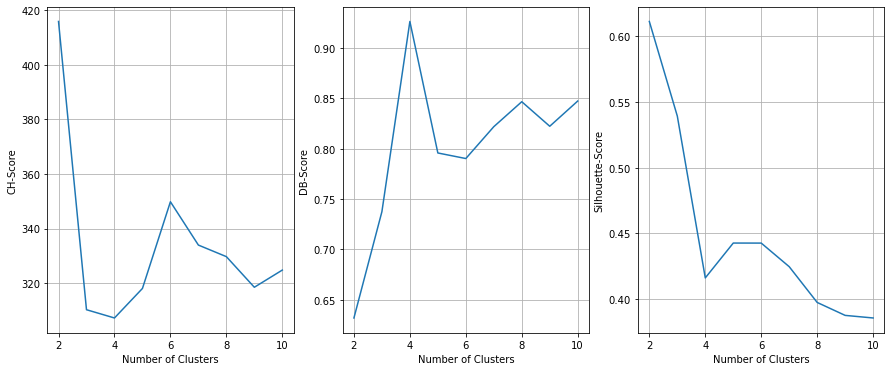

In [5]:
## c) Estimating the number of clusters for this dataset using the Calinski-Harabasz, Davies-Bouldin, 
## and Silhouette scores

## Defining the input data
X = customers[['Gender', 'Age_0_1', 'Annual_Income_0_1']]

## Defining empty lists to store results
ch_score = []
db_score = []
sil_score = []

## Defining list of clusters to consider
num_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for i in num_clusters:
    
    ## Fitting the k-means model
    kmeans_md = KMeans(n_clusters = i, init = 'k-means++', n_init = 20).fit(X)
    
    ## Computing and storing the Ch score
    ch_score.append(calinski_harabasz_score(X, kmeans_md.labels_))
    
    ## Computing and storing the DB score
    db_score.append(davies_bouldin_score(X, kmeans_md.labels_))
    
    ## Computing and storing the Silhouette score
    sil_score.append(silhouette_score(X, kmeans_md.labels_))

## Visualizing the Calinski-Harabasz, Davies-Bouldin, and Silhouette scores.
fig, axs = plt.subplots(1, 3, figsize = (15, 6))
axs[0].plot(num_clusters, ch_score)
axs[0].set_xlabel('Number of Clusters')
axs[0].set_ylabel('CH-Score')
axs[0].grid()

axs[1].plot(num_clusters, db_score)
axs[1].set_xlabel('Number of Clusters')
axs[1].set_ylabel('DB-Score')
axs[1].grid()

axs[2].plot(num_clusters, sil_score)
axs[2].set_xlabel('Number of Clusters')
axs[2].set_ylabel('Silhouette-Score')
axs[2].grid()

## The CH-Score, DB-Score, and Silhouette-Score each indicate that two clusters in the optimal number to consider.
## Therefore, we will cluster the data into two clusters.

In [6]:
## d) Using the results from part (c) to cluster the data into two clusters

## Fitting the k-means model
kmeans_md = KMeans(n_clusters = 2, init = 'k-means++', n_init = 20).fit(X)

## Appending cluster labels to the data
customers['Cluster'] = kmeans_md.labels_

In [7]:
## e) Describing each of the clusters

## Cluster 1

cluster_1 = customers[customers['Cluster'] == 0]
cluster_1.describe()

## All customers in this cluster are males. The average age is around 40 years old with an average income
## of around $62,000.

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Age_0_1,Annual_Income_0_1,Cluster
count,88.000000,88.0,88.000000,88.000000,88.000000,88.000000,88.000000,88.0
mean,104.238636,1.0,39.806818,62.227273,48.511364,0.419362,0.387109,0.0
std,57.483830,0.0,15.514812,26.638373,27.896770,0.298362,0.218347,0.0
min,1.000000,1.0,18.000000,15.000000,1.000000,0.000000,0.000000,0.0
25%,59.500000,1.0,27.750000,45.500000,24.500000,0.187500,0.250000,0.0
50%,106.500000,1.0,37.000000,62.500000,50.000000,0.365385,0.389344,0.0
75%,151.250000,1.0,50.500000,78.000000,70.000000,0.625000,0.516393,0.0
max,200.000000,1.0,70.000000,137.000000,97.000000,1.000000,1.000000,0.0


In [8]:
## Cluster 2

cluster_2 = customers[customers['Cluster'] == 1]
cluster_2.describe()

## All customers in this cluster are females. The average age is around 38 years old with an average income
## of around $59,000. This cluster also has a spending score that is, on average, three points higher compared
## to Cluster 1.

## I think the clustering result does make sense because it perfectly split the two genders presented
## in the data set and the two clusters have distinct differences.

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Age_0_1,Annual_Income_0_1,Cluster
count,112.000000,112.0,112.000000,112.000000,112.000000,112.000000,112.000000,112.0
mean,97.562500,0.0,38.098214,59.250000,51.526786,0.386504,0.362705,1.0
std,58.276412,0.0,12.644095,26.011952,24.114950,0.243156,0.213213,0.0
min,3.000000,0.0,18.000000,16.000000,5.000000,0.000000,0.008197,1.0
25%,46.750000,0.0,29.000000,39.750000,35.000000,0.211538,0.202869,1.0
50%,94.500000,0.0,35.000000,60.000000,50.000000,0.326923,0.368852,1.0
75%,148.250000,0.0,47.500000,77.250000,73.000000,0.567308,0.510246,1.0
max,197.000000,0.0,68.000000,126.000000,99.000000,0.961538,0.909836,1.0
